# FigS6
Plot 48 traces from dataset1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from zebrafish_ms2_paper.trace_analysis import extract_traces, remove_blips, predict_protein, predict_protein_v2, compute_trace_uncertainty, enforce_1spot_per_nucleus
import pandas as pd
import pickle
            

In [2]:
"""specify the paths to the required datasets"""
path_to_dataset1 = r'/media/brandon/Data1/Somitogenesis/Dorado/rerun_quantification_July7_2023/filtered_df.pkl'#"ADD_PATH_TO_DATASET1_HERE"
path_to_non_blank_timepoints = r'/media/brandon/Data1/Somitogenesis/Dorado/non_blank_timepoints_full.pkl'#"ADD_PATH_TO_NON_BLANK_TIMEPOINTS_HERE"

In [6]:
"""plot params"""
linewidth = 4
fontweight = 'bold'
fontsize = 24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
rc('axes', linewidth=2)

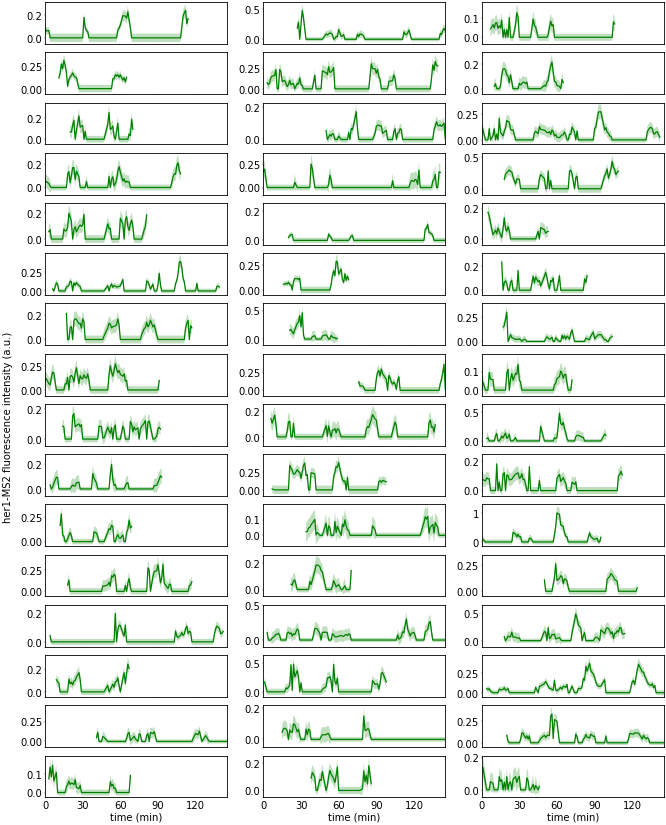

In [7]:
df = pd.read_pickle(path_to_dataset1)
with open(path_to_non_blank_timepoints,'rb') as fp:
    non_blank_timepoints = pickle.load(fp)
    
minimum_number_of_spots = 20

df = enforce_1spot_per_nucleus(df, method='gauss3d_dog')

# extract culled traces
traces = extract_traces(df, method='gauss3d_dog')

# filter traces by length
trace_len = [np.sum(trace[1] > 0) for trace in traces]
traces = [zipped[0] for zipped in zip(traces, trace_len) if zipped[1] > minimum_number_of_spots ]
good_ids = [trace[2] for trace in traces]
df = df[[nid in good_ids for nid in df.nucleus_id.tolist()]]

plt.figure(figsize=(3.13 * 8.5, 3.13 * 11), dpi=30)
fontweight = 'bold'
fontsize = 24
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
counter = 0
max_inten = df.gauss3d_dog.max()

traces_to_plot = 48
for i, trace in enumerate(traces):
    if counter > traces_to_plot - 1:
         continue
    t_arr, inten_arr, nucleus = trace
    t_arr = non_blank_timepoints[t_arr.astype('int')]

    # for trace uncertainty
    sub_df = df[df.nucleus_id == nucleus]
    t_arr_bkg = sub_df.t.values
    bkg_arr = sub_df.offset.values
    t_arr_bkg = t_arr_bkg[~np.isnan(bkg_arr)]
    bkg_arr = bkg_arr[~np.isnan(bkg_arr)]
    s = compute_trace_uncertainty(t_arr_bkg, bkg_arr, inten_arr)
    l = inten_arr - s
    u = inten_arr + s
    
    counter += 1
    plt.subplot(int(traces_to_plot / 3), 3, counter)
    plt.plot(t_arr, inten_arr / max_inten, 'g-', linewidth=3, label='MS2')
    plt.fill_between(t_arr, l / max_inten, u / max_inten, facecolor='g', alpha=0.25)
    
    plt.xlim([0, 145])

    if counter == traces_to_plot - 1:
        plt.xticks([0, 30, 60, 90, 120])
        plt.xlabel('time (min)', fontsize=fontsize)
    elif counter == traces_to_plot:
        plt.xticks([0, 30, 60, 90, 120])
        plt.xlabel('time (min)', fontsize=fontsize)
    elif counter == traces_to_plot - 2:
        plt.xticks([0, 30, 60, 90, 120])
        plt.xlabel('time (min)', fontsize=fontsize)
    else:
        plt.xticks([0, 30, 60, 90, 120], labels=[])
    

    if counter == 25:
        plt.ylabel('her1-MS2 fluorescence intensity (a.u.) \n', fontsize=fontsize)


    ax = plt.gca()
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)